In [2]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [3]:
import keras
from keras import layers
import keras_tuner as kt
import pickle
from sklearn.model_selection import train_test_split

In [4]:
# Import the modules
from google.colab import drive
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
def model_builder(hp):
    model = keras.Sequential()

    # First Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu'
    ))

    model.add(layers.Flatten())

    # Fully Connected Dense Layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dense(
        units=hp.Int('dense_units_2', min_value=32, max_value=256, step=32),
        activation='relu'
    ))

    # Output Layer
    model.add(layers.Dense(6, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Load already augmented data from saved pickle files
X_train_aug = pickle.load(open("/content/drive/My Drive/X_train_aug.pkl", "rb"))
y_train_aug = pickle.load(open("/content/drive/My Drive/y_train_aug.pkl", "rb"))
X_test = pickle.load(open("/content/drive/My Drive/X_test.pkl", "rb"))
y_test = pickle.load(open("/content/drive/My Drive/y_test.pkl", "rb"))

# further split the training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_aug, y_train_aug, test_size=0.2, random_state=42)

In [57]:
# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=20,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='keras_tuner_results',
    project_name='cnn_hp_tuning_random_search'
)

# Perform Hyperparameter Search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and Train the Best Model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate on Test Data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Trial 20 Complete [00h 01m 49s]
val_accuracy: 0.8222344517707825

Best val_accuracy So Far: 0.8345257639884949
Total elapsed time: 01h 09m 39s
Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5547 - loss: 1.1308 - val_accuracy: 0.7443 - val_loss: 0.7111
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7563 - loss: 0.6777 - val_accuracy: 0.7859 - val_loss: 0.5873
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8117 - loss: 0.5240 - val_accuracy: 0.8127 - val_loss: 0.5283
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8628 - loss: 0.3894 - val_accuracy: 0.8109 - val_loss: 0.5197
Epoch 5/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8903 - loss: 0.3069 - val_accuracy: 0.8202 - val_loss: 0.5186
Epoch 6/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9157 - loss: 0.2293 - val_accuracy: 0.8187 - val_loss: 0.5725
Epoch 7/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9457 - lo

In [59]:
display(best_hps.values)

{'conv_1_filters': 160,
 'conv_1_kernel': 3,
 'conv_2_filters': 128,
 'conv_2_kernel': 3,
 'conv_3_filters': 256,
 'conv_3_kernel': 5,
 'dense_units': 96,
 'dense_units_2': 64,
 'learning_rate': 0.0001}

In [66]:
best_tuned_model = tuner.get_best_models(1)[0]
tuned_hp = tuner.get_best_hyperparameters(1)[0]

model_loss, model_accuracy = best_tuned_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {model_accuracy:.4f}\nTest Loss: {model_loss:.4f}\n")
display(f"Best Hyperparameters: {tuned_hp.values}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8159 - loss: 0.7796
Test Accuracy: 0.8180
Test Loss: 0.7389



"Best Hyperparameters: {'conv_1_filters': 160, 'conv_1_kernel': 3, 'conv_2_filters': 128, 'conv_2_kernel': 3, 'conv_3_filters': 256, 'conv_3_kernel': 5, 'dense_units': 96, 'dense_units_2': 64, 'learning_rate': 0.0001}"

In [67]:
optimum_model = tuner.hypermodel.build(tuned_hp)
optimum_model.fit(X_train, y_train, epochs=7, validation_data=(X_val, y_val))

model_loss, model_accuracy = optimum_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {model_accuracy:.4f}\nTest Loss: {model_loss:.4f}\n")
display(f"Best Hyperparameters: {tuned_hp.values}")

Epoch 1/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5348 - loss: 1.1723 - val_accuracy: 0.7204 - val_loss: 0.7483
Epoch 2/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7585 - loss: 0.6577 - val_accuracy: 0.7971 - val_loss: 0.5699
Epoch 3/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8127 - loss: 0.5185 - val_accuracy: 0.8103 - val_loss: 0.5301
Epoch 4/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8508 - loss: 0.4070 - val_accuracy: 0.8087 - val_loss: 0.5380
Epoch 5/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.8828 - loss: 0.3283 - val_accuracy: 0.8386 - val_loss: 0.4562
Epoch 6/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9135 - loss: 0.2403 - val_accuracy: 0.8397 - val_loss: 0.4818
Epoch 7/7
682/682 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.9333 - loss: 0.1894 - val_accuracy: 0.8243 - val_loss: 0.5207
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8250 - loss: 0.6056
Test Accuracy: 0.8303

"Best Hyperparameters: {'conv_1_filters': 160, 'conv_1_kernel': 3, 'conv_2_filters': 128, 'conv_2_kernel': 3, 'conv_3_filters': 256, 'conv_3_kernel': 5, 'dense_units': 96, 'dense_units_2': 64, 'learning_rate': 0.0001}"

In [69]:
optimum_model.save("/content/drive/My Drive/project/models/tuned_model_randomsearch.keras")

In [70]:
optimum_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 160)       │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 160)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 128)         │         184,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 96)                  │      25,165,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,542,708 (299.62 MB)

 Trainable params: 26,180,902 (99.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,361,806 (199.74 MB)

In [71]:
optimum_model.evaluate(X_test, y_test)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8250 - loss: 0.6056


[0.5872045755386353, 0.8303492665290833]

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get all trials and results
trials = tuner.oracle.get_best_trials(num_trials=20)  # Get top 10 trials

# Extract data
trial_data = []
for trial in trials:
    trial_data.append({
        'trial_id': trial.trial_id,
        'conv_1_filters': trial.hyperparameters.get('conv_1_filters'),
        'conv_2_filters': trial.hyperparameters.get('conv_2_filters'),
        'conv_3_filters': trial.hyperparameters.get('conv_3_filters'),
        'dense_units': trial.hyperparameters.get('dense_units'),
        'dense_units_2': trial.hyperparameters.get('dense_units_2'),
        'kernel_size': trial.hyperparameters.get('conv_1_kernel'),
        'learning_rate': trial.hyperparameters.get('learning_rate'),
        'val_accuracy': trial.metrics.get_best_value('val_accuracy'),
        'val_loss': trial.metrics.get_best_value('val_loss')
    })

# Convert to DataFrame
df = pd.DataFrame(trial_data)

<Figure size 1000x500 with 0 Axes>

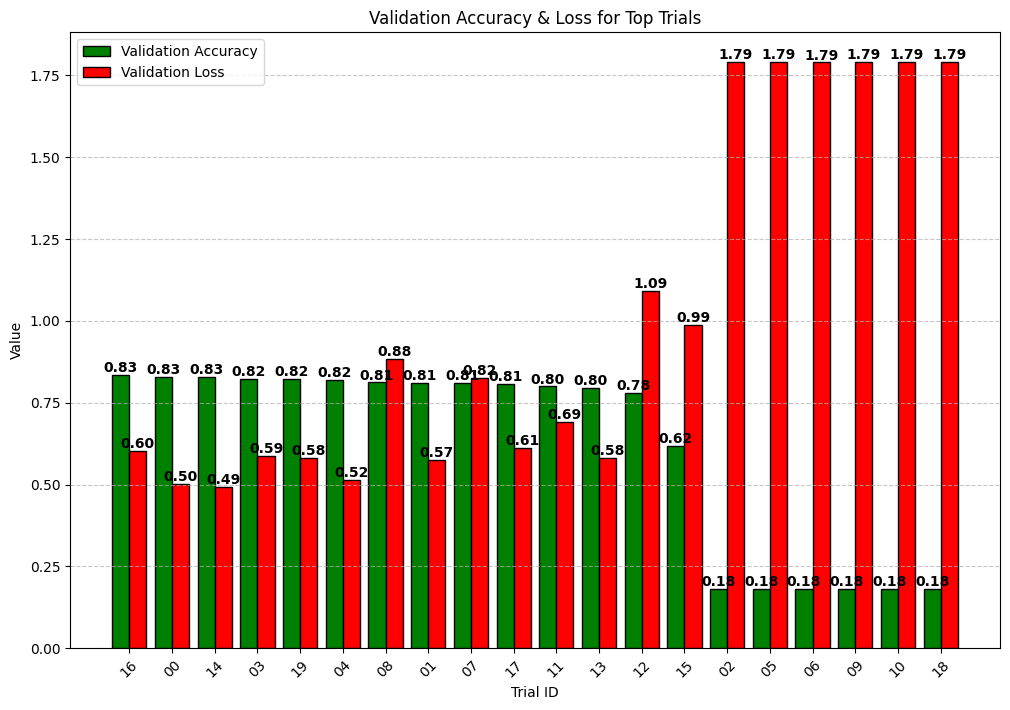

In [96]:


# Define color gradient based on accuracy
colors = plt.cm.Greens(np.linspace(1, 0.4, len(df)))


plt.figure(figsize=(10, 5))
df_sorted = df.sort_values(by="val_accuracy", ascending=False)

# Define Bar Width
bar_width = 0.4

# Create Figure
fig, ax = plt.subplots(figsize=(12, 8))

# Set positions for bars
x = np.arange(len(df_sorted))

# Plot Bars for Accuracy
bars1 = ax.bar(x - bar_width/2, df_sorted['val_accuracy'], bar_width, label='Validation Accuracy', color='green', edgecolor='black')

# Plot Bars for Loss
bars2 = ax.bar(x + bar_width/2, df_sorted['val_loss'], bar_width, label='Validation Loss', color='red', edgecolor='black')

# Add Data Labels for Accuracy
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add Data Labels for Loss
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Labels and Title
ax.set_xlabel('Trial ID')
ax.set_ylabel('Value')
ax.set_title('Validation Accuracy & Loss for Top Trials')
ax.set_xticks(x)
ax.set_xticklabels(df_sorted['trial_id'], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

In [91]:
display(df)

,trial_id,conv_1_filters,conv_2_filters,conv_3_filters,dense_units,dense_units_2,kernel_size,learning_rate,val_accuracy,val_loss
0,16,160,128,256,96,64,3,0.0001,0.834526,0.601675
1,00,96,160,96,64,160,5,0.0001,0.828839,0.502672
2,14,128,160,192,96,160,5,0.0001,0.827922,0.493218
3,03,32,32,64,256,128,5,0.0001,0.823152,0.588161
4,19,96,32,160,160,160,3,0.0001,0.822234,0.582755
5,04,32,192,96,32,160,5,0.0001,0.819666,0.515238
6,08,192,224,160,192,96,5,0.0001,0.811961,0.883144
7,01,96,64,192,96,64,5,0.0001,0.810493,0.574271
8,07,192,64,224,128,64,5,0.0001,0.809393,0.824913
9,17,224,256,128,32,128,3,0.0010,0.807191,0.611667


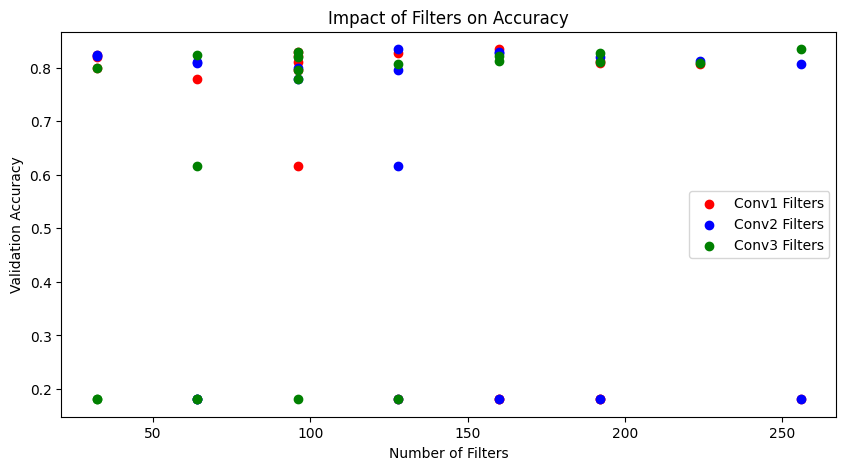

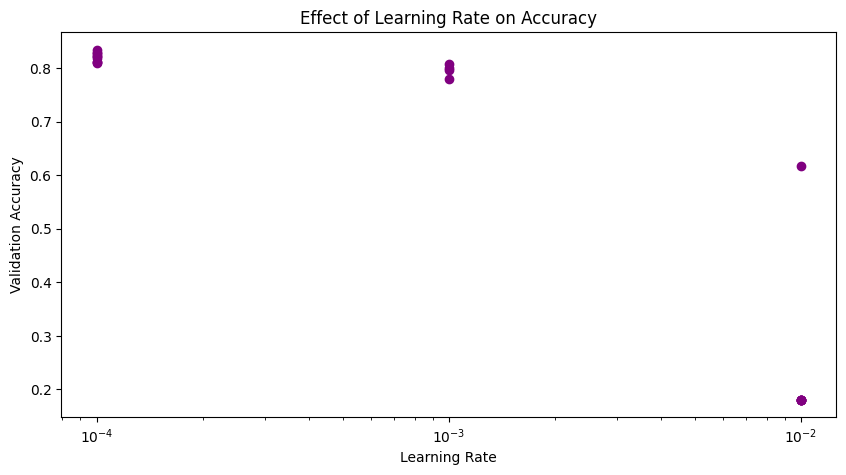

In [92]:
# Effect of Convolutional Filters on Accuracy
plt.figure(figsize=(10, 5))
plt.scatter(df['conv_1_filters'], df['val_accuracy'], label='Conv1 Filters', color='red')
plt.scatter(df['conv_2_filters'], df['val_accuracy'], label='Conv2 Filters', color='blue')
plt.scatter(df['conv_3_filters'], df['val_accuracy'], label='Conv3 Filters', color='green')
plt.xlabel("Number of Filters")
plt.ylabel("Validation Accuracy")
plt.title("Impact of Filters on Accuracy")
plt.legend()
plt.show()

# Effect of Learning Rate on Accuracy
plt.figure(figsize=(10, 5))
plt.scatter(df['learning_rate'], df['val_accuracy'], color='purple')
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.xscale('log')  # Log scale for learning rate
plt.title("Effect of Learning Rate on Accuracy")
plt.show()

In [5]:
def model_builder_2(hp):
    model = keras.Sequential()

    # First Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation=hp.Choice('conv_1_activation', values=['relu', 'tanh', 'selu'])
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation=hp.Choice('conv_2_activation', values=['relu', 'tanh', 'selu'])
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation=hp.Choice('conv_3_activation', values=['relu', 'tanh', 'selu'])
    ))

    model.add(layers.Flatten())

    # Fully Connected Dense Layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'selu'])
    ))
    model.add(layers.Dense(
        units=hp.Int('dense_units_2', min_value=32, max_value=256, step=32),
        activation=hp.Choice('dense_activation_2', values=['relu', 'tanh', 'selu'])
    ))

    # Output Layer
    model.add(layers.Dense(6, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [8]:
# Initialize Hyperband tuner
tuner = kt.Hyperband(
    model_builder_2,
    objective='val_accuracy',
    max_epochs=20,  # Max epochs to train the best models
    factor=3,  # Reduction factor
    directory='hyperband_results',
    project_name='cnn_hyperband_tuning'
)

# Start the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=16)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best parameters found
print(f"""
Best Hyperparameters:
- Conv1 Filters: {best_hps.get('conv_1_filters')}
- Conv1 Kernel: {best_hps.get('conv_1_kernel')}
- Conv1 Activation: {best_hps.get('conv_1_activation')}
- Conv2 Filters: {best_hps.get('conv_2_filters')}
- Conv2 Kernel: {best_hps.get('conv_2_kernel')}
- Conv2 Activation: {best_hps.get('conv_2_activation')}
- Conv3 Filters: {best_hps.get('conv_3_filters')}
- Conv3 Kernel: {best_hps.get('conv_3_kernel')}
- Conv3 Activation: {best_hps.get('conv_3_activation')}
- Dense Units: {best_hps.get('dense_units')}
- Dense Activation: {best_hps.get('dense_activation')}
- Dense Units 2: {best_hps.get('dense_units_2')}
- Dense Activation 2: {best_hps.get('dense_activation_2')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 06m 46s]
val_accuracy: 0.8203999400138855

Best val_accuracy So Far: 0.8332415819168091
Total elapsed time: 01h 08m 00s

Best Hyperparameters:
- Conv1 Filters: 64
- Conv1 Kernel: 3
- Conv1 Activation: selu
- Conv2 Filters: 256
- Conv2 Kernel: 3
- Conv2 Activation: relu
- Conv3 Filters: 96
- Conv3 Kernel: 5
- Conv3 Activation: relu
- Dense Units: 224
- Dense Activation: tanh
- Dense Units 2: 32
- Dense Activation 2: selu
- Learning Rate: 0.0001



In [9]:
# Build and train the best model
hypertuned_model = tuner.hypermodel.build(best_hps)
history = hypertuned_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate on test data
test_loss, test_acc = hypertuned_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}\n")

Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5663 - loss: 1.1382 - val_accuracy: 0.7338 - val_loss: 0.7259
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7490 - loss: 0.6787 - val_accuracy: 0.7542 - val_loss: 0.6698
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8243 - loss: 0.4871 - val_accuracy: 0.7722 - val_loss: 0.6168
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8635 - loss: 0.3817 - val_accuracy: 0.8019 - val_loss: 0.5496
Epoch 5/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9070 - loss: 0.2633 - val_accuracy: 0.8232 - val_loss: 0.5406
Epoch 6/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9436 - loss: 0.1690 - val_accuracy: 0.8114 - val_loss: 0.5878
Epoch 7/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9734 - loss: 0.0916 - val_accuracy: 0.8043 - val_loss: 0.6886
Epoch 8/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9853 - loss: 0.0561 - 